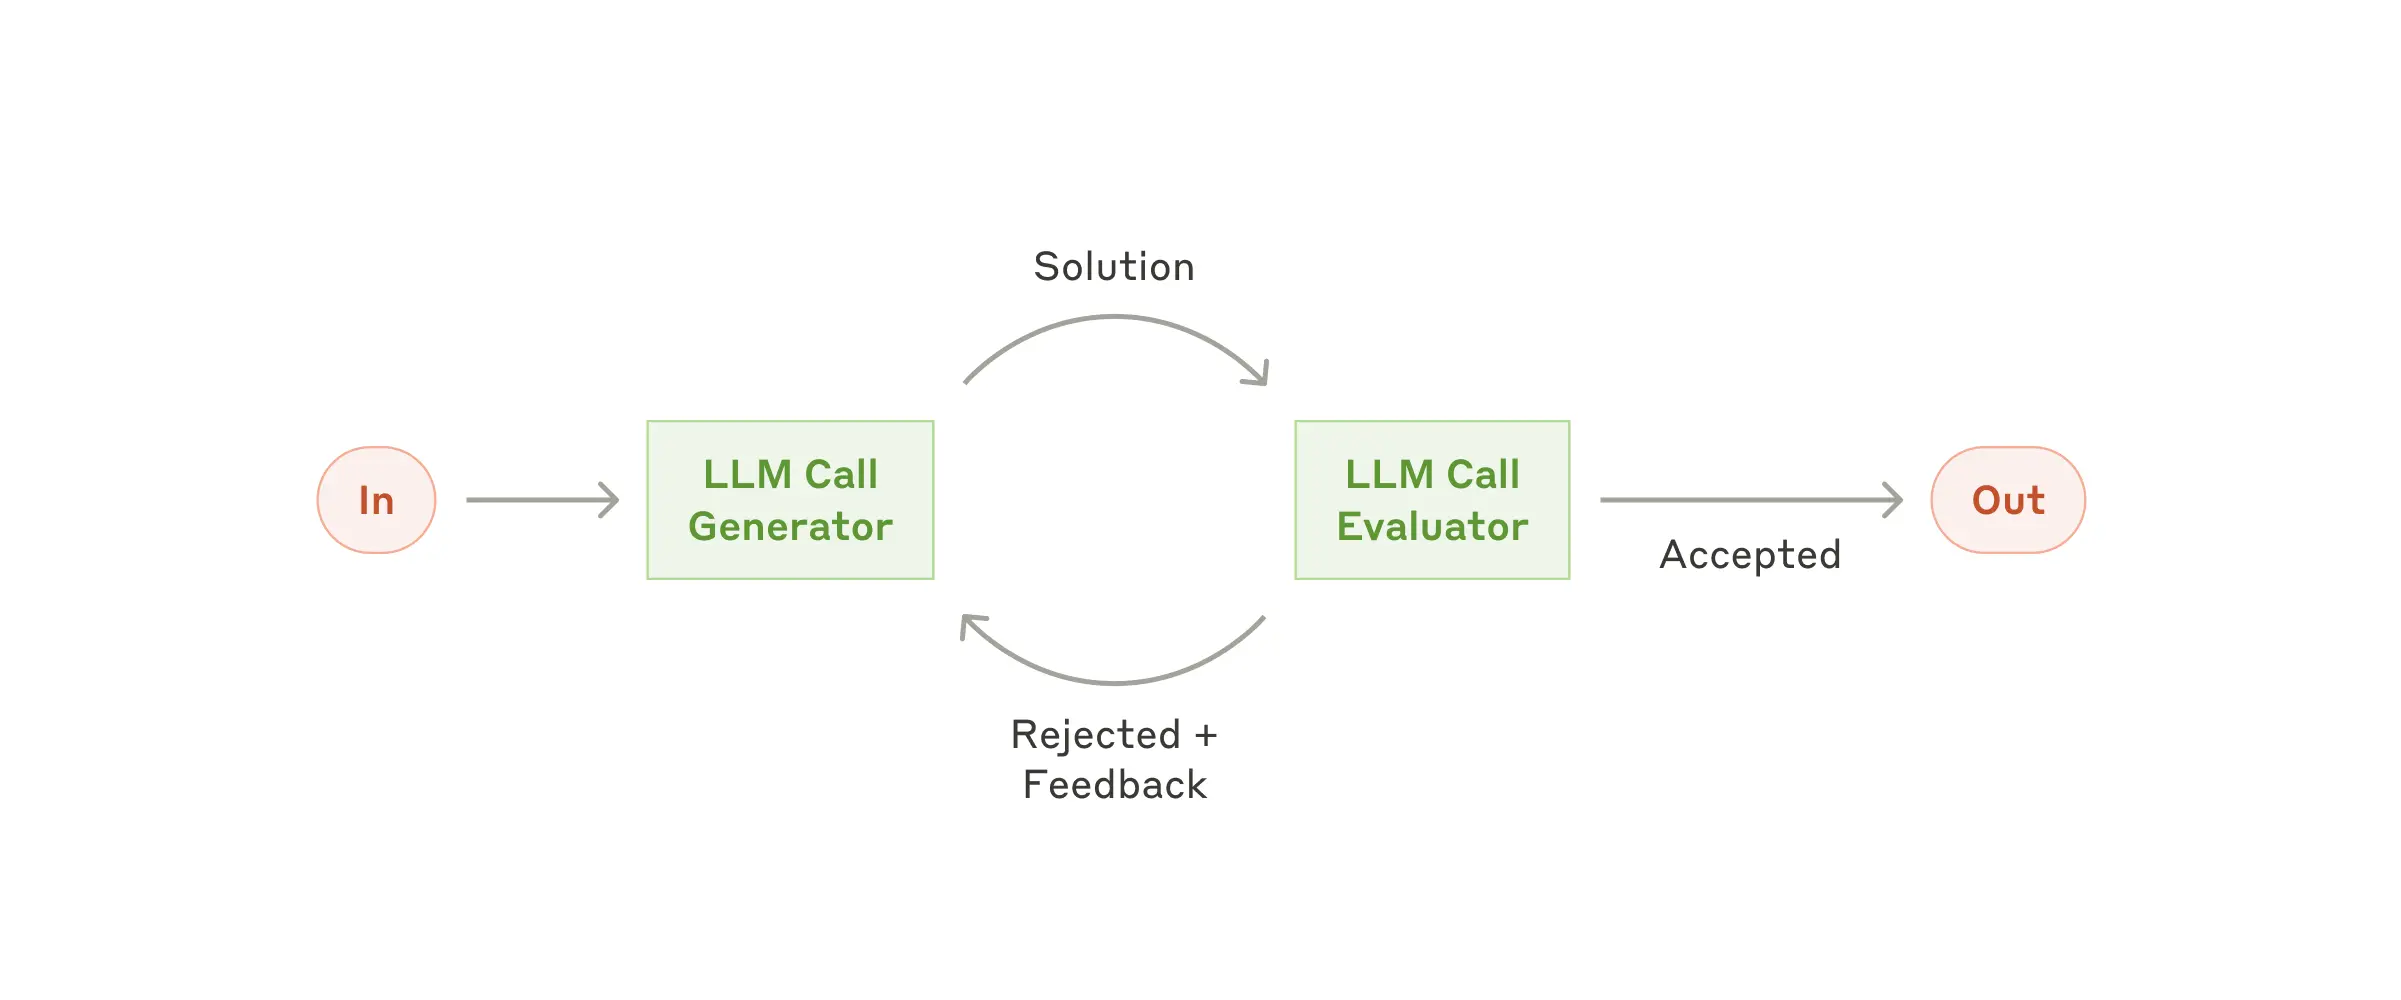

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Enter {var}: ")
    else:
        print(f"{var} already set")
        
_set_env("OPENAI_API_KEY")

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

OPENAI_API_KEY already set


In [2]:
from pydantic import BaseModel, Field
from typing import List, Literal
class FeedBack(BaseModel):
    grade: Literal['funny', 'not funny'] = Field(description="Decide if the joke is funny or not.")
    feedback: str = Field(description="if the joke is not funny provide feedback on how to improve it.")
    
evaluator = llm.with_structured_output(FeedBack)

In [10]:
# Graph State
from typing import TypedDict
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


def llm_call_generator(state: State):
    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}",
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    
    return {"joke": msg.content}

def llm_call_evaluator(state: State):
    grade = evaluator.invoke(f"Grade the joke {state['joke']} based on indian taste")
    print(grade)
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}

def route_joke(state: State):
    if state['funny_or_not'] == 'funny':
        return 'Accepted'
    elif state['funny_or_not'] == 'not funny':
        return 'Rejected + Feedback'

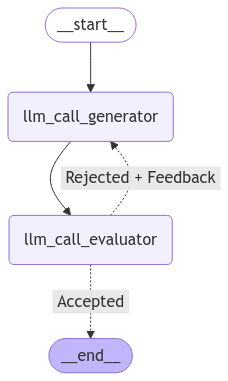

In [11]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [12]:
# Invoke
state = optimizer_workflow.invoke({"topic": "Sumit Indian Boy"})
print(state["joke"])

grade='funny' feedback=''
Why did Sumit, the Indian boy, bring a ladder to school?

Because he wanted to go to high school!
